In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats import multitest

In [2]:
!mkdir analysis_potentiators

mkdir: cannot create directory ‘analysis_potentiators’: File exists


In [6]:

def qq_plot(df, p_val_column, pval_threshold=None, ylim=None, savefile=None):

    """
    makes a QQ plot of the data
    """

    df = df.sort_values(p_val_column, ascending=False)

    length = len(df)

    increment = 1./length

    expected_p_values = np.arange(1,0,-increment)

    fig = plt.figure(figsize = (5,5))
    ax = fig.gca()
    
    p_val_plot_real = -np.log10(df[p_val_column].astype(float))
    p_val_plot_expected = -np.log10(expected_p_values)[0:len(p_val_plot_real)]
    
    ax.scatter(p_val_plot_expected, p_val_plot_real, s=8, color=df.color)
    ax.plot(p_val_plot_expected, p_val_plot_expected, color="grey")
    
    if pval_threshold:
        ax.axhline(-np.log10(pval_threshold), color="grey")
    
    sns.despine()
    ax.set_xlabel("-log10 expected P values")
    ax.set_ylabel("-log10 real P values")
    if ylim:
        ax.set_ylim(ylim)
    
        upper_bound = ylim[-1]
        n_excluded = sum(p_val_plot_real > upper_bound)
        ax.text(x=1.5,y=upper_bound-1, s=f"{n_excluded} points above axis")
        
    if savefile:
        plt.savefig(savefile)
    
    plt.show()

def create_table(drug):
    association_files = glob.glob(f"output/{drug}_potentiators/2.run_output/*assoc.txt")
    single = pd.read_csv(f"output/{drug}_potentiators/{drug}_mutation_count_table.csv", index_col=0, dtype=object)
    data = pd.DataFrame()
    
    print(f"found {len(association_files)} assoc files")

    for assoc_file in association_files:
        
        d = pd.read_csv(assoc_file, sep="\t", dtype=object, index_col=0, engine="python")
        
        if len(d)==0:
            print("error for", assoc_file)
            continue
            
        # because these are all cross hits, each file contains position i, position j, and cross
        # annotate each entry with the identities of i,j, and cross
        # position j = mutation that happened first (ie, background)
        position_i, position_j = assoc_file.split("/")[-1].split("_")[0:2]
        _s = single.query("position_i==@position_i and position_j==@position_j")
        
        d["N_first"] = list(_s.N_j)[0]
        d["N_second"] = list(_s.N_i)[0]
        d["N_cross"]  = list(_s.N_ij)[0]
        d["first_mutation"] = position_j
        d["second_mutation"] = position_i
        
        data = pd.concat([data, d])

    # Removing duplicate positions
    print("before removing duplicates", len(data))
    data = data.drop_duplicates(subset=["rs", "p_wald", "beta"])
    print("after removing duplicates", len(data))
    
    data["p_wald"] = data["p_wald"].astype(float)
    data = data.sort_values("p_wald").reset_index()
    
    data = data[[
                "rs", "first_mutation", "second_mutation", "n_miss", "af", 
                "beta", 'p_wald', "se", "N_first", "N_second", "N_cross"
            ]]
    
    return data

def add_annotation(data, sequential_annotation_file, potentiator_annotation_file):

    data = data.reset_index()
    # read in for mutations that occur simultaneously or after the initial AB mutation - in this case
    # The known mutation is position_j
    sequential_annotation = pd.read_csv(sequential_annotation_file, dtype=object, engine="python")
    
    data = data.merge(
        sequential_annotation[['position_i', 'gene_name_i', 'position_j', 'gene_name_j']], 
        right_on=["position_i", "position_j"], 
        left_on = ["second_mutation", "first_mutation"],
        how="left"
    )
    
    data.rename(columns={
        "position_i": "test_position", 
        "position_j": "known_position", 
        "gene_name_i": "second_gene_name", 
        "gene_name_j": "first_gene_name"
    }, inplace=True)

    # get those that merged successfully and those that did not
    data_sequential = data.loc[data.test_position.notnull(), :]
    data_sequential["type"] = "sequential"
    print(len(data_sequential))
    data_potentiator = data.loc[data.test_position.isnull(), :]
    data_potentiator["type"] = "potentiator"
    print(len(data_potentiator))
    
    # read in for mutations that occur simultaneously or after the initial AB mutation - in this case
    # The known mutation is position_j
    data_potentiator = data_potentiator.drop(["test_position", "known_position", "second_gene_name", "first_gene_name"], axis=1)
    
    potentiator_annotation = pd.read_csv(potentiator_annotation_file, dtype=object, engine="python")

    data_potentiator = data_potentiator.merge(
        potentiator_annotation[['position_i', 'gene_name_i', 'position_j', 'gene_name_j']], 
        right_on=["position_i", "position_j"], 
        left_on = [ "second_mutation", "first_mutation"],
        how="left"
    )
    
    data_potentiator.rename(columns = {
        "position_j": "test_position", 
        "position_i": "known_position", 
        "gene_name_i": "second_gene_name", 
        "gene_name_j": "first_gene_name"
    }, inplace=True)
    
    data = pd.concat([data_sequential, data_potentiator])
    
    known_positions = set(data.known_position)
    new_positions = set(data.test_position)

    data["known"] = [x in known_positions for x in data.rs]
    data['cross'] = ["_" in x for x in data.rs]

    c1, c2, c3 = "black", "red", "blue"

    data['color'] = None
    for idx, row in data.iterrows():
        if row.known:
            data.loc[idx,'color'] = c1
        elif row.cross:
            data.loc[idx,'color'] = c3
        else:
            data.loc[idx,'color'] = c2
            
    return data

found 431 assoc files
before removing duplicates 913
after removing duplicates 351
27
324


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


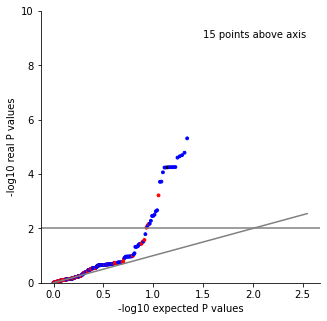

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
39,732110.0,1473246.0,732110.0,1473246.0,732110.0,sequential,1.161270e+00,8.044625e-03,170.0,8.0,3.0,rrs,hadA
40,732110.0_1473246.0,1473246.0,732110.0,1473246.0,732110.0,sequential,1.748137e+00,9.378974e-03,170.0,8.0,3.0,rrs,hadA
0,1473246.0,1473246.0,3497859.0,3497859.0,1473246.0,potentiator,2.886292e+00,5.233342e-177,0.0,170.0,0.0,devS,None
1,1473246.0_1287112.0,1473246.0,1287112.0,1287112.0,1473246.0,potentiator,2.885623e+00,7.620236e-177,1208.0,170.0,170.0,None,None
2,1473246.0_2626108.0,1473246.0,2626108.0,2626108.0,1473246.0,potentiator,2.824540e+00,2.292357e-156,1199.0,170.0,162.0,esxO,None
3,1473246.0_2626191.0,1473246.0,2626191.0,2626191.0,1473246.0,potentiator,2.751289e+00,3.730451e-133,1187.0,170.0,156.0,None,None
4,1473246.0_2626189.0,1473246.0,2626189.0,2626189.0,1473246.0,potentiator,2.721407e+00,3.937205e-128,1184.0,170.0,155.0,None,None
5,1473246.0_1341040.0,1473246.0,1341040.0,1341040.0,1473246.0,potentiator,2.773475e+00,1.632563e-122,1059.0,170.0,150.0,esxL,None
6,1473246.0_1341044.0,1473246.0,1341044.0,1341044.0,1473246.0,potentiator,2.719438e+00,6.811597e-114,973.0,170.0,149.0,esxL,None
7,1473246.0_2338994.0,1473246.0,2338994.0,2338994.0,1473246.0,potentiator,1.989600e+00,9.373809e-31,883.0,170.0,127.0,Rv2082,None


In [7]:
ALPHA = 0.1
drug = "KANAMYCIN"

data = create_table(drug)

data = add_annotation(data, f"../output/05.antibiotic/KAN_antibiotic_hits.csv", 
                      f"../output/05.antibiotic/KAN_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 482 assoc files
before removing duplicates 1188
after removing duplicates 580
142
467


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


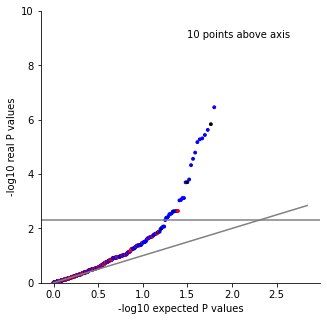

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,761155.0,761155.0,856111.0,761155.0,856111.0,sequential,2.272281e+00,9.224577e-29,678.0,0.0,0.0,rpoB,Rv0762c
6,761110.0,761110.0,2338741.0,761110.0,2338741.0,sequential,2.257828e+00,3.736264e-15,169.0,0.0,0.0,rpoB,Rv2082
20,2155168.0,2155168.0,3065197.0,2155168.0,3065197.0,sequential,9.511259e-01,1.575547e-04,848.0,0.0,0.0,katG,Rv2752c
24,332951.0_761110.0,761110.0,332951.0,761110.0,332951.0,sequential,1.577086e+00,7.635859e-04,169.0,99.0,52.0,rpoB,vapC25
0,761155.0_1287112.0,761155.0,1287112.0,1287112.0,761155.0,potentiator,2.210062e+00,6.525856e-28,1488.0,678.0,667.0,None,rpoB
1,761155.0_2626191.0,761155.0,2626191.0,2626191.0,761155.0,potentiator,2.085502e+00,1.473228e-26,1461.0,678.0,650.0,None,rpoB
2,761155.0_2626108.0,761155.0,2626108.0,2626108.0,761155.0,potentiator,2.068921e+00,6.061159e-26,1475.0,678.0,655.0,esxO,rpoB
3,761155.0_2626189.0,761155.0,2626189.0,2626189.0,761155.0,potentiator,2.038703e+00,8.291334e-26,1458.0,678.0,648.0,None,rpoB
4,761155.0_1341040.0,761155.0,1341040.0,1341040.0,761155.0,potentiator,1.571457e+00,5.128587e-17,1308.0,678.0,559.0,esxL,rpoB
5,761110.0_2626108.0,761110.0,2626108.0,2626108.0,761110.0,potentiator,2.168567e+00,2.657726e-14,1475.0,169.0,168.0,esxO,rpoB


In [120]:

drug = "RIFAMPICIN"
annotation_files = []

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/RIF_antibiotic_hits.csv", f"../output/05.antibiotic/RIF_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 291 assoc files
before removing duplicates 660
after removing duplicates 355
170
186


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


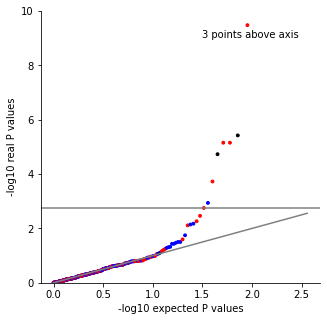

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,2155168.0,2155168.0,2176276.0,2155168.0,2176276.0,sequential,1.992117e+00,1.307646e-22,838.0,0.0,0.0,katG,lipD
3,1638364.0_2155168.0,2155168.0,1638364.0,2155168.0,1638364.0,sequential,1.082415e+00,3.323926e-10,838.0,1255.0,698.0,katG,None
7,2123182.0_2155168.0,2155168.0,2123182.0,2155168.0,2123182.0,sequential,1.372000e+00,1.876841e-04,838.0,118.0,96.0,katG,Rv1873
8,332951.0_2155168.0,2155168.0,332951.0,2155168.0,332951.0,sequential,1.421067e+00,1.147673e-03,838.0,99.0,82.0,katG,vapC25
0,2155168.0_1287112.0,2155168.0,1287112.0,1287112.0,2155168.0,potentiator,1.846700e+00,5.812883e-20,1465.0,838.0,827.0,None,katG
1,2155168.0_1341040.0,2155168.0,1341040.0,1341040.0,2155168.0,potentiator,1.299377e+00,1.469425e-13,1290.0,838.0,701.0,esxL,katG
2,1674048.0,1674048.0,2155541.0,2155541.0,1674048.0,potentiator,1.492355e+00,3.777089e-06,11.0,27.0,2.0,katG,fabG1
3,2726141.0,2155168.0,2726141.0,2726141.0,2155168.0,potentiator,1.524624e+00,7.007969e-06,58.0,838.0,42.0,r_ahpC,katG
4,2726141.0,2155168.0,2726141.0,2726141.0,2155168.0,potentiator,1.524624e+00,7.007969e-06,58.0,838.0,42.0,r_ahpC,katG
5,1673425.0,1673425.0,1674484.0,1674484.0,1673425.0,potentiator,1.053416e+00,1.855795e-05,0.0,238.0,0.0,inhA,r_fabG1


In [121]:

drug = "ISONIAZID"


data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/INH_antibiotic_hits.csv", f"../output/05.antibiotic/INH_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 481 assoc files
before removing duplicates 1092
after removing duplicates 459
222
260


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


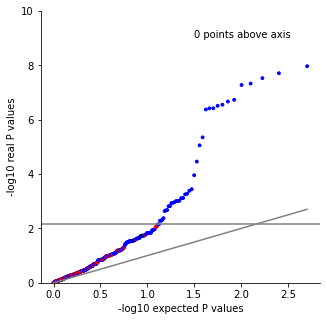

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,4247429.0,4247429.0,2487024.0,4247429.0,2487024.0,sequential,5.585805e-01,1.074432e-08,222.0,1.0,0.0,embB,Rv2219A
2,4247431.0,4247431.0,973061.0,4247431.0,973061.0,sequential,5.177203e-01,2.949228e-08,218.0,0.0,0.0,embB,Rv0874c
17,4248003.0,4248003.0,1968190.0,4248003.0,1968190.0,sequential,4.821193e-01,4.120467e-04,50.0,0.0,0.0,embB,Rv1742
30,1638364.0_4247429.0,4247429.0,1638364.0,4247429.0,1638364.0,sequential,2.970992e-01,2.104287e-03,222.0,1249.0,164.0,embB,None
35,4243217.0,4247729.0,4243217.0,4247729.0,4243217.0,sequential,3.911003e-01,5.181356e-03,43.0,41.0,0.0,embB,r_embC
36,4243217.0,4247729.0,4243217.0,4247729.0,4243217.0,sequential,3.911003e-01,5.181356e-03,43.0,41.0,0.0,embB,r_embC
37,4247729.0,4247729.0,4243217.0,4247729.0,4243217.0,sequential,3.778647e-01,7.115613e-03,43.0,41.0,0.0,embB,r_embC
38,4247729.0,4247729.0,4243217.0,4247729.0,4243217.0,sequential,3.778647e-01,7.115613e-03,43.0,41.0,0.0,embB,r_embC
0,4247429.0_1287112.0,4247429.0,1287112.0,1287112.0,4247429.0,potentiator,5.459015e-01,1.943555e-08,1456.0,222.0,218.0,None,embB
1,4247429.0_2626108.0,4247429.0,2626108.0,2626108.0,4247429.0,potentiator,5.304308e-01,4.669956e-08,1443.0,222.0,217.0,esxO,embB


In [122]:

drug = "ETHAMBUTOL"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/EMB_antibiotic_hits.csv", 
                      f"../output/05.antibiotic/EMB_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 910 assoc files
before removing duplicates 1785
after removing duplicates 552
60
494


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


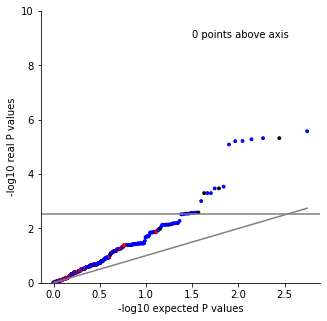

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
11,2288839.0,2288839.0,2288727.0,2288839.0,2288727.0,sequential,1.196627e+00,0.000502,13.0,0.0,0.0,pncA,pncA
12,2288839.0,2288839.0,2288727.0,2288839.0,2288727.0,sequential,1.196627e+00,0.000502,13.0,0.0,0.0,pncA,pncA
0,2289213.0_2338994.0,2289213.0,2338994.0,2338994.0,2289213.0,potentiator,1.269288e+00,0.000003,775.0,57.0,52.0,Rv2082,pncA
1,2289213.0_1287112.0,2289213.0,1287112.0,1287112.0,2289213.0,potentiator,1.140848e+00,0.000005,1104.0,57.0,57.0,None,pncA
2,2289213.0,2289213.0,3894732.0,3894732.0,2289213.0,potentiator,1.140848e+00,0.000005,106.0,57.0,3.0,PPE60,pncA
3,2289213.0_2626108.0,2289213.0,2626108.0,2626108.0,2289213.0,potentiator,1.136328e+00,0.000005,1096.0,57.0,57.0,esxO,pncA
4,2289213.0_2626191.0,2289213.0,2626191.0,2626191.0,2289213.0,potentiator,1.128689e+00,0.000006,1096.0,57.0,57.0,None,pncA
5,2289213.0_2626189.0,2289213.0,2626189.0,2626189.0,2289213.0,potentiator,1.127714e+00,0.000006,1094.0,57.0,57.0,None,pncA
6,2289213.0_1341040.0,2289213.0,1341040.0,1341040.0,2289213.0,potentiator,1.153422e+00,0.000008,960.0,57.0,54.0,esxL,pncA
7,2289231.0_1341040.0,2289231.0,1341040.0,1341040.0,2289231.0,potentiator,1.208546e+00,0.000291,960.0,13.0,13.0,esxL,pncA


In [123]:
drug = "PYRAZINAMIDE"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/PZA_antibiotic_hits.csv", f"../output/05.antibiotic/PZA_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 591 assoc files
before removing duplicates 1283
after removing duplicates 565
130
437


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


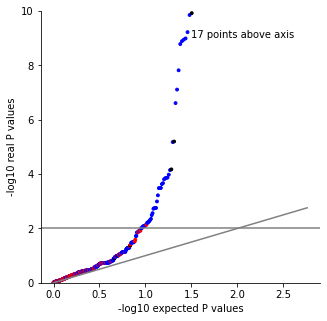

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,781687.0,781687.0,1276588.0,1276588.0,781687.0,potentiator,2.279595e+00,6.340025e-34,443.0,147.0,105.0,Rv1148c,rpsL
1,781687.0_1287112.0,781687.0,1287112.0,1287112.0,781687.0,potentiator,2.284758e+00,1.074223e-33,1456.0,147.0,146.0,None,rpsL
2,781687.0_1341040.0,781687.0,1341040.0,1341040.0,781687.0,potentiator,2.239923e+00,7.073799e-32,1283.0,147.0,141.0,esxL,rpsL
3,781687.0_1341044.0,781687.0,1341044.0,1341044.0,781687.0,potentiator,2.231190e+00,1.023212e-31,1188.0,147.0,141.0,esxL,rpsL
4,781687.0_2626108.0,781687.0,2626108.0,2626108.0,781687.0,potentiator,2.204581e+00,7.041937e-31,1443.0,147.0,142.0,esxO,rpsL
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,781687.0_1036583.0,781687.0,1036583.0,1036583.0,781687.0,potentiator,1.371868e+00,8.308607e-03,36.0,147.0,27.0,pstC2,rpsL
60,781687.0_787318.0,781687.0,787318.0,787318.0,781687.0,potentiator,1.370775e+00,8.359770e-03,36.0,147.0,27.0,Rv0687,rpsL
61,1472359.0_4060588.0,1472359.0,4060588.0,4060588.0,1472359.0,potentiator,9.996530e-01,9.144248e-03,253.0,34.0,20.0,esxW,rrs
62,1472359.0_3894732.0,1472359.0,3894732.0,3894732.0,1472359.0,potentiator,9.926406e-01,9.663972e-03,220.0,34.0,20.0,PPE60,rrs


In [124]:
drug = "STREPTOMYCIN"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/STM_antibiotic_hits.csv", f"../output/05.antibiotic/STM_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 429 assoc files
before removing duplicates 926
after removing duplicates 366
31
335


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


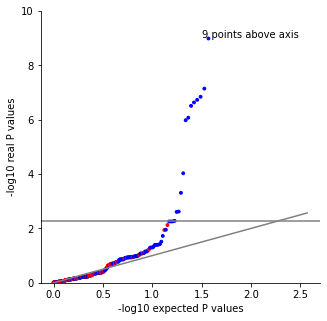

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,1473246.0,1473246.0,3497859.0,3497859.0,1473246.0,potentiator,3.160434e+00,1.459486e-134,0.0,154.0,0.0,devS,rrs
1,1473246.0_1287112.0,1473246.0,1287112.0,1287112.0,1473246.0,potentiator,3.157075e+00,3.207928e-134,1200.0,154.0,154.0,None,rrs
2,1473246.0_2626108.0,1473246.0,2626108.0,2626108.0,1473246.0,potentiator,3.028497e+00,7.776912e-121,1184.0,154.0,146.0,esxO,rrs
3,1473246.0_1341040.0,1473246.0,1341040.0,1341040.0,1473246.0,potentiator,3.061126e+00,7.921248e-110,1061.0,154.0,137.0,esxL,rrs
4,1473246.0_2626191.0,1473246.0,2626191.0,2626191.0,1473246.0,potentiator,2.973708e+00,9.062100e-109,1172.0,154.0,140.0,None,rrs
5,1473246.0_2626189.0,1473246.0,2626189.0,2626189.0,1473246.0,potentiator,2.932088e+00,8.267066e-106,1169.0,154.0,139.0,None,rrs
6,1473246.0_1341044.0,1473246.0,1341044.0,1341044.0,1473246.0,potentiator,2.994126e+00,1.542651e-100,978.0,154.0,136.0,esxL,rrs
7,1473246.0_2338994.0,1473246.0,2338994.0,2338994.0,1473246.0,potentiator,2.761828e+00,2.980103e-58,864.0,154.0,117.0,Rv2082,rrs
8,1473246.0_2122395.0,1473246.0,2122395.0,2122395.0,1473246.0,potentiator,1.783434e+00,4.649392e-19,331.0,154.0,81.0,lldD2,rrs
9,1473246.0_3894732.0,1473246.0,3894732.0,3894732.0,1473246.0,potentiator,1.424313e+00,1.026147e-09,166.0,154.0,57.0,PPE60,rrs


In [125]:
drug = "AMIKACIN"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/AMI_antibiotic_hits.csv",
                      f"../output/05.antibiotic/AMI_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 299 assoc files
before removing duplicates 593
after removing duplicates 259
22
237


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


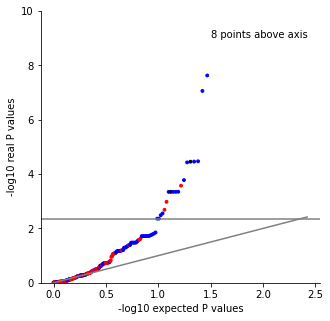

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,1473246.0_2626108.0,1473246.0,2626108.0,2626108.0,1473246.0,potentiator,1.913222e+00,6.550273e-53,1094.0,136.0,135.0,esxO,rrs
1,1473246.0,1473246.0,3497859.0,3497859.0,1473246.0,potentiator,1.905956e+00,8.738855e-53,0.0,136.0,0.0,devS,rrs
2,1473246.0_1287112.0,1473246.0,1287112.0,1287112.0,1473246.0,potentiator,1.905956e+00,8.738855e-53,1096.0,136.0,136.0,None,rrs
3,1473246.0_2626191.0,1473246.0,2626191.0,2626191.0,1473246.0,potentiator,1.903830e+00,1.876250e-52,1094.0,136.0,135.0,None,rrs
4,1473246.0_2626189.0,1473246.0,2626189.0,2626189.0,1473246.0,potentiator,1.886935e+00,3.324288e-51,1092.0,136.0,134.0,None,rrs
5,1473246.0_1341040.0,1473246.0,1341040.0,1341040.0,1473246.0,potentiator,1.843019e+00,3.521978e-42,951.0,136.0,117.0,esxL,rrs
6,1473246.0_1341044.0,1473246.0,1341044.0,1341044.0,1473246.0,potentiator,1.773670e+00,8.827551e-38,865.0,136.0,115.0,esxL,rrs
7,1473246.0_2338994.0,1473246.0,2338994.0,2338994.0,1473246.0,potentiator,1.679936e+00,2.131918e-24,786.0,136.0,98.0,Rv2082,rrs
8,1473246.0_1276588.0,1473246.0,1276588.0,1276588.0,1473246.0,potentiator,1.177703e+00,2.356328e-08,328.0,136.0,48.0,Rv1148c,rrs
9,1473246.0_2122395.0,1473246.0,2122395.0,2122395.0,1473246.0,potentiator,1.149936e+00,8.725127e-08,256.0,136.0,53.0,lldD2,rrs


In [126]:
drug = "CAPREOMYCIN"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/CAP_antibiotic_hits.csv", f"../output/05.antibiotic/CAP_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 183 assoc files
before removing duplicates 244
after removing duplicates 112
28
84


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


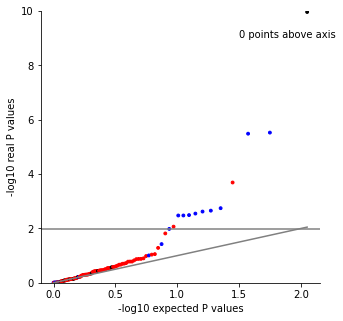

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
1,1674481.0,1674481.0,1533471.0,1674481.0,1533471.0,sequential,1.141944e+00,2.978756e-06,27.0,0.0,0.0,inhA,PPE19
5,1532777.0_1674481.0,1674481.0,1532777.0,1674481.0,1532777.0,sequential,9.873782e-01,2.214362e-03,27.0,225.0,13.0,inhA,PPE19
7,1674048.0,1674048.0,4327480.0,1674048.0,4327480.0,sequential,6.872210e-01,2.838585e-03,25.0,2.0,0.0,fabG1,r_ethR
0,1673425.0,1673425.0,1674484.0,1674484.0,1673425.0,potentiator,8.491287e-01,1.087603e-10,0.0,202.0,0.0,inhA,r_fabG1
1,1674481.0_2030521.0,1674481.0,2030521.0,2030521.0,1674481.0,potentiator,1.137506e+00,3.263263e-06,1204.0,27.0,27.0,esxM,inhA
2,1674263.0,1673425.0,1674263.0,1674263.0,1673425.0,potentiator,9.315934e-01,2.041322e-04,35.0,202.0,34.0,inhA,r_fabG1
3,1673425.0_1674263.0,1673425.0,1674263.0,1674263.0,1673425.0,potentiator,8.062872e-01,1.797954e-03,35.0,202.0,34.0,inhA,r_fabG1
4,1674481.0_2829918.0,1674481.0,2829918.0,2829918.0,1674481.0,potentiator,1.259219e+00,2.393973e-03,168.0,27.0,8.0,None,inhA
5,1673425.0_1674782.0,1673425.0,1674782.0,1674782.0,1673425.0,potentiator,2.194741e+00,3.233475e-03,4.0,202.0,2.0,inhA,r_fabG1
6,1674481.0_2338990.0,1674481.0,2338990.0,2338990.0,1674481.0,potentiator,1.070822e+00,3.334994e-03,883.0,27.0,13.0,Rv2082,inhA


In [127]:
drug = "ETHIONAMIDE"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/ETA_antibiotic_hits.csv", f"../output/05.antibiotic/ETA_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

found 242 assoc files
before removing duplicates 582
after removing duplicates 258
5
255


/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ag300/anaconda3/envs/jupytervenv2/lib/python3.7/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


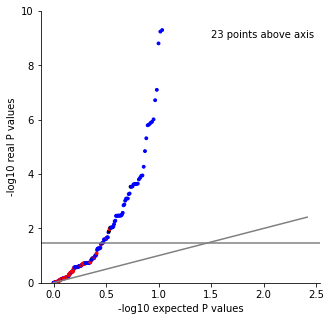

,rs,known_position,test_position,first_mutation,second_mutation,type,beta,p_wald,N_first,N_second,N_cross,first_gene_name,second_gene_name
0,7582.0_2626191.0,7582.0,2626191.0,2626191.0,7582.0,potentiator,2.296313e+00,1.293079e-31,1065.0,58.0,53.0,None,gyrA
1,7582.0_2626189.0,7582.0,2626189.0,2626189.0,7582.0,potentiator,2.271528e+00,1.306782e-31,1062.0,58.0,54.0,None,gyrA
2,7582.0,7582.0,1532879.0,1532879.0,7582.0,potentiator,2.174443e+00,4.652318e-30,0.0,58.0,0.0,PPE19,gyrA
3,7582.0_1287112.0,7582.0,1287112.0,1287112.0,7582.0,potentiator,2.174709e+00,4.669367e-30,1088.0,58.0,58.0,None,gyrA
4,7582.0_2626108.0,7582.0,2626108.0,2626108.0,7582.0,potentiator,2.172131e+00,8.598076e-30,1077.0,58.0,56.0,esxO,gyrA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,7581.0_2986827.0,7581.0,2986827.0,2986827.0,7581.0,potentiator,2.587870e+00,2.518513e-02,22.0,17.0,1.0,Rv2670c,gyrA
84,7570.0_75233.0,7570.0,75233.0,75233.0,7570.0,potentiator,7.951360e-01,2.521100e-02,173.0,39.0,19.0,None,gyrA
85,7570.0_3894732.0,7570.0,3894732.0,3894732.0,7570.0,potentiator,7.930684e-01,2.554202e-02,143.0,39.0,19.0,PPE60,gyrA
86,7570.0_340132.0,7570.0,340132.0,340132.0,7570.0,potentiator,7.326689e-01,3.261275e-02,207.0,39.0,20.0,PPE3,gyrA


In [128]:
drug = "MOXIFLOXACIN"

data = create_table(drug)
data = add_annotation(data, f"../output/05.antibiotic/MOXI_antibiotic_hits.csv", f"../output/05.antibiotic/MOXI_potentiator_antibiotic_hits.csv")

## Apply significance cutoffs using BH
data["significant"] = multitest.multipletests(data.p_wald, alpha=ALPHA, method='fdr_bh')[0]
minimum_significant = data.query("significant").p_wald.max()

qq_plot(data, "p_wald", pval_threshold=minimum_significant, ylim=[0,10], savefile=f"analysis_potentiators/{drug}_qq.pdf")

sig = data.query("significant")
data.to_csv(f"analysis_potentiators/{drug}_hit_table.csv")
sig[["rs", "known_position", "test_position", "first_mutation", "second_mutation", "type",
     "beta", "p_wald", "N_first", "N_second", "N_cross", "first_gene_name", "second_gene_name"]]

### Detailed analysis of which results were found per drug

In [5]:
files = glob.glob("analysis_potentiators/*hit_table.csv")

all_first_mutations = []
for file in files:
    print(file)
    table = pd.read_csv(file, index_col = 0)
    
    table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)
    
    potentiators = table.query("type=='potentiator' and not known")
    potentiators_single = potentiators.drop_duplicates(["first_mutation", "first_gene_name"])
    #print(potentiators_single.sort_values("first_mutation")[["first_mutation", "first_gene_name"]])
    for idx, row in potentiators_single.iterrows():
        all_first_mutations.append(f"{int(row.first_mutation)}_{row.first_gene_name}")
    
# construct a matrix on a drug, frist mutation basis
all_first_mutations = sorted(list(set(all_first_mutations)))

mat = np.zeros(shape=(len(files), len(all_first_mutations)))
drug_list = []
for idx,file in enumerate(files):
    #print(file)
    drug = file.split("/")[-1].split("_hit_table.csv")[0]
    drug_list.append(drug)
    table = pd.read_csv(file, index_col = 0)
    
    table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)
    
    potentiators = table.query("type=='potentiator' and not known")
    potentiators_single = potentiators.drop_duplicates(["first_mutation", "first_gene_name"])
    
    potentiators_single = potentiators.drop_duplicates(["first_mutation", "first_gene_name"])
    #print(potentiators_single.sort_values("first_mutation")[["first_mutation", "first_gene_name"]])
    for _, row in potentiators_single.iterrows():
        jdx = all_first_mutations.index(f"{int(row.first_mutation)}_{row.first_gene_name}")
        #print(idx, jdx)
        if row.cross:
            mat[idx, jdx] += 2
        else:
            #print(row)
            mat[idx, jdx] += 1

analysis_potentiators/KANAMYCIN_hit_table.csv
analysis_potentiators/AMIKACIN_hit_table.csv
analysis_potentiators/CAPREOMYCIN_hit_table.csv
analysis_potentiators/MOXIFLOXACIN_hit_table.csv
analysis_potentiators/ETHIONAMIDE_hit_table.csv
analysis_potentiators/ISONIAZID_hit_table.csv
analysis_potentiators/STREPTOMYCIN_hit_table.csv
analysis_potentiators/PYRAZINAMIDE_hit_table.csv
analysis_potentiators/RIFAMPICIN_hit_table.csv
analysis_potentiators/ETHAMBUTOL_hit_table.csv


<AxesSubplot:>

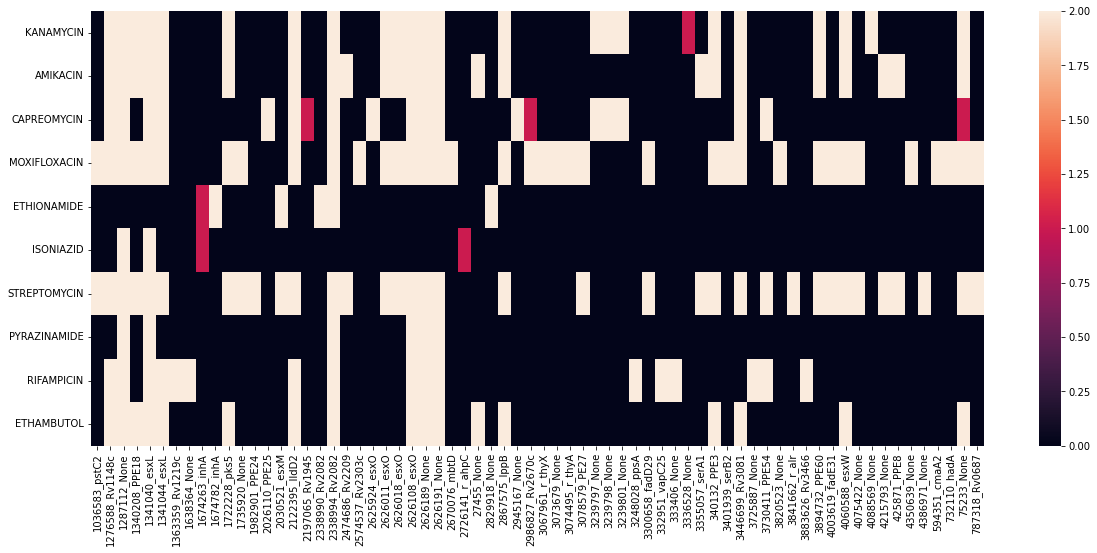

In [6]:
figure = plt.figure(figsize=(20,8))
sns.heatmap(mat,xticklabels=all_first_mutations, yticklabels =drug_list)


In [7]:
files = glob.glob("analysis_potentiators/*hit_table.csv")

combined_results = []

for file in files:
    print(file)
    drug = file.split("/")[-1].split("_hit_table.csv")[0]
    table = pd.read_csv(file, index_col = 0)
    table["drug"] = drug
    table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)
    
    potentiators = table.query("type=='sequential' and not known")
    potentiators_single = potentiators.drop_duplicates(["rs", "second_mutation", "second_gene_name"])
    combined_results.append(potentiators_single)
    
combined_results = pd.concat(combined_results)

analysis_potentiators/KANAMYCIN_hit_table.csv
analysis_potentiators/AMIKACIN_hit_table.csv
analysis_potentiators/CAPREOMYCIN_hit_table.csv
analysis_potentiators/MOXIFLOXACIN_hit_table.csv
analysis_potentiators/ETHIONAMIDE_hit_table.csv
analysis_potentiators/ISONIAZID_hit_table.csv
analysis_potentiators/STREPTOMYCIN_hit_table.csv
analysis_potentiators/PYRAZINAMIDE_hit_table.csv
analysis_potentiators/RIFAMPICIN_hit_table.csv
analysis_potentiators/ETHAMBUTOL_hit_table.csv


In [8]:
combined_results[['rs', 'first_mutation', 'second_mutation', 'drug',
       'beta', 'p_wald', 'N_first', 'N_second', 'N_cross',
       'test_position', 'second_gene_name', 'known_position',
       'first_gene_name', 
]]

,rs,first_mutation,second_mutation,drug,beta,p_wald,N_first,N_second,N_cross,test_position,second_gene_name,known_position,first_gene_name
39,732110.0,1473246.0,732110.0,KANAMYCIN,1.161270,8.044625e-03,170.0,8.0,3.0,732110.0,hadA,1473246.0,rrs
40,732110.0_1473246.0,1473246.0,732110.0,KANAMYCIN,1.748137,9.378974e-03,170.0,8.0,3.0,732110.0,hadA,1473246.0,rrs
5,1532777.0_1674481.0,1674481.0,1532777.0,ETHIONAMIDE,0.987378,2.214362e-03,27.0,225.0,13.0,1532777.0,PPE19,1674481.0,inhA
3,1638364.0_2155168.0,2155168.0,1638364.0,ISONIAZID,1.082415,3.323926e-10,838.0,1255.0,698.0,1638364.0,None,2155168.0,katG
7,2123182.0_2155168.0,2155168.0,2123182.0,ISONIAZID,1.372000,1.876841e-04,838.0,118.0,96.0,2123182.0,Rv1873,2155168.0,katG
8,332951.0_2155168.0,2155168.0,332951.0,ISONIAZID,1.421067,1.147673e-03,838.0,99.0,82.0,332951.0,vapC25,2155168.0,katG
24,332951.0_761110.0,761110.0,332951.0,RIFAMPICIN,1.577086,7.635859e-04,169.0,99.0,52.0,332951.0,vapC25,761110.0,rpoB
30,1638364.0_4247429.0,4247429.0,1638364.0,ETHAMBUTOL,0.297099,2.104287e-03,222.0,1249.0,164.0,1638364.0,None,4247429.0,embB
35,4243217.0,4247729.0,4243217.0,ETHAMBUTOL,0.391100,5.181356e-03,43.0,41.0,0.0,4243217.0,r_embC,4247729.0,embB


## Of the 20 potentiating mutations found, what fraction have an epistatic hit? 

In [18]:
potentiators_20 = pd.read_csv("../output/potentiator_mutations.csv", index_col = 0)
potentiators_20

,Unnamed: 0.1,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,is_lineage
201,20051,75233,C,['A'],intergenic,NaN,None,None,False
489,73834,340132,G,['A'],Rv0280,768.0,PE/PPE,PPE3,False
632,95481,454333,T,['G'],Rv0376c,1103.0,Non-Essential,Rv0376c,False
1491,239536,1276588,C,['G'],Rv1148c,288.0,Non-Essential,Rv1148c,False
1512,241057,1287112,T,['C'],intergenic,NaN,None,None,False
1598,250896,1340208,G,['A'],Rv1196,859.0,PE/PPE,PPE18,False
1620,251012,1341040,C,"['A', 'T']",Rv1198,34.0,Antigen,esxL,False
1621,251014,1341044,C,['T'],Rv1198,38.0,Antigen,esxL,False
2011,315778,1722228,A,"['C', 'T', 'G']",Rv1527c,145.0,Non-Essential,pks5,False
2353,384755,2122395,C,['T'],Rv1872c,488.0,Antigen,lldD2,False


In [26]:
files = glob.glob("analysis_potentiators/*hit_table.csv")

potentiators_list = list(potentiators_20.pos)
num_drugs_epistatic = np.zeros(len(potentiators_list))

all_first_mutations = []
for file in files:
    table = pd.read_csv(file, index_col = 0)
    
    table = table.query("significant")
    table["known"] = table["rs"].astype(str)==table["known_position"].astype(str)
    
    potentiators = table.query("type=='potentiator' and not known")
    potentiators_single = potentiators.drop_duplicates(["first_mutation", "first_gene_name"])
    #print(potentiators_single.sort_values("first_mutation")[["first_mutation", "first_gene_name"]])
    for idx, row in potentiators_single.iterrows():
        all_first_mutations.append(int(row.first_mutation))
        if int(row.first_mutation) in potentiators_list:
            i = potentiators_list.index(int(row.first_mutation))
            num_drugs_epistatic[i] += 1
        


In [28]:
x = pd.DataFrame({"pos":potentiators_list, "num_drugs":num_drugs_epistatic})
potentiators_20 = potentiators_20.merge(x, on="pos", how="left")
potentiators_20

,Unnamed: 0.1,pos,ref,alt,gene_id,gene_pos,gene_category,gene_name,is_lineage,num_drugs
0,20051,75233,C,['A'],intergenic,NaN,None,None,False,6.0
1,73834,340132,G,['A'],Rv0280,768.0,PE/PPE,PPE3,False,5.0
2,95481,454333,T,['G'],Rv0376c,1103.0,Non-Essential,Rv0376c,False,0.0
3,239536,1276588,C,['G'],Rv1148c,288.0,Non-Essential,Rv1148c,False,7.0
4,241057,1287112,T,['C'],intergenic,NaN,None,None,False,9.0
5,250896,1340208,G,['A'],Rv1196,859.0,PE/PPE,PPE18,False,5.0
6,251012,1341040,C,"['A', 'T']",Rv1198,34.0,Antigen,esxL,False,9.0
7,251014,1341044,C,['T'],Rv1198,38.0,Antigen,esxL,False,7.0
8,315778,1722228,A,"['C', 'T', 'G']",Rv1527c,145.0,Non-Essential,pks5,False,5.0
9,384755,2122395,C,['T'],Rv1872c,488.0,Antigen,lldD2,False,7.0


In [19]:
epistatic_potentiators = set(all_first_mutations)
potentiators = set(potentiators_20.pos)

print(len(potentiators.intersection(epistatic_potentiators)))

19


In [24]:
potentiators_list

[75233,
 340132,
 454333,
 1276588,
 1287112,
 1340208,
 1341040,
 1341044,
 1722228,
 2122395,
 2338994,
 2626011,
 2626018,
 2626108,
 2626189,
 2626191,
 2867575,
 3446699,
 3894732,
 4060588]